# Lecture 11: 2023-02-03 Naive Bayes Classification

## Lecture Overview

- Classification as a Machine Learning Problem and Human Learning Problem
- Naive Bayes Classification Formal Definitions
- Naive Bayes Classification Example
- Refactoring Code for Naive Bayes Classification
  - Naive Bayes Classification Example: Spam Filtering
  - Naive Bayes Classification Example: Twitter Sentiment Analysis
- Beyond Naivete: Where Naive Bayes Classification Breaks Down

## Classification as a Machine Learning Problem and Human Learning Problem

<img align="right" style="float: right; padding: 0px 0px 0px 3px;" src="https://pictures.abebooks.com/inventory/31359579518.jpg" height="500" width="400"> "Categorization is not a matter to be taken lightly. There is nothing more basic than categorization to our thought, perception, action, and speech. Every time we see something as a kind of thing, for example, a tree, we are categorizing. Whenever we reason about kinds of things--chairs, nations, illnesses, emotions, any kind of thing at all--we are employing categories." [5-6] --[George Lakoff](https://en.wikipedia.org/wiki/George_Lakoff)


In machine learning we can think of classification as a problem of assigning a label to an input. In human learning we can think of classification as a problem of assigning a label to an input. In both cases, the labels are discrete categories. In both cases, the inputs are features. In both cases, the goal is to learn a function that maps inputs to labels.

Some examples of classification problems:

* Spam detection
* Sentiment analysis
* Language identification
* Authorship identification
* Topic identification
* Part-of-speech tagging

"The goal of classification is to take a single observation, extract some useful features, and thereby classify the observation into one of a set of discrete classes." [59] Jurafsky and Martin.

## Naive Bayes Classification Formal Definitions

Machine learning overview:

<img src="./images/Neuron.drawio.png">

### Inputs, Outputs, and Features

* `Inputs = features = x`

* `Outputs = labels or categories = y` = $Y \in \{c_1, c_2, \ldots, c_n\}$

* Training set = $X_{train} = \{(x_1, c_1), (x_2, c_2), \ldots, (x_m, c_m)\}$ 

* Validation set = $y_{val} = \{(y_1, c_1), (y_2, c_2), \ldots, (y_m, c_m)\}$

* Test set = $X_{test} = \{(x_1, c_1), (x_2, c_2), \ldots, (x_m, c_m)\}$

### Bayesian Inference

Bayes (1701-1761) was an English mathematician and statistician. He is known for his work on probability theory, including the law of total probability, the law of conditional probability, and the Bayes theorem. Bayes theorem is a fundamental result in statistics and machine learning. It is used to compute the posterior probability of an event given some evidence.

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$


Thus, when we train we are computing the posterior probability of a label given some evidence. When we test we are computing the posterior probability of a label given some evidence.

$$\hat{c} = argmax_{c\in C} P(c|d) = argmax_{c\in C} \frac{P(d|c)P(c)}{P(d)}$$

We can simplify the above equation by dropping the denominator $P(d)$ because it is the same for all $c$.

$$\hat{y} = argmax_{c\in C} P(c|d) = argmax_{c\in C} P(d|c)P(c)$$

### Prior Probability and Likelihood

Choose the class with the highest product of two probabilities: the prior probability of the class and the likelihood of the data given the class.

$\hat{c} = argmax_{c\in C} P(c|d) =$ likelihood $P(d|c)$ prior $P(c)$


### Naive Bayes Assumption

We have used the bag of words method in previous lectures. We are assuming that the order of the words in a document does not matter. We are assuming that the words in a document are independent of each other. This is the Naive Bayes assumption. It is a useful assumption because it allows us to simplify the computation of the likelihood. We can compute the likelihood by multiplying the probabilities of the individual words.

$$P(d|c) = P(w_1, w_2, \ldots, w_n|c) = P(w_1|c)P(w_2|c)\ldots P(w_n|c)$$

Ergo,

$$c_{NB} = argmax_{c\in C} P(c) = \prod_{i\in positions} P(w_i|c)$$

We can optimize compute time by using the log of the likelihood. Postions = all word positions in the document.

$$c_{NB} = argmax_{c\in C} P(c) = \sum_{i\in positions} log(P(w_i|c))$$

### Pseudo-Code from Jurafsky and Martin (63)

```markdown

function Train Naive Bayes(D,C) returns log P(c) and log P(w|c)
    for each class c in C do
        N_doc ← number of documents in D
        N_c ← total number of documents in D in class c
        logprior(c) ← log(N_c/N_doc)
        V ← vocabulary of all words in D
        bigdoc ← all words in documents with class c
        for each word w in V do # calculate log P(w|c) terms
            N_cw ← number of times w occurs in bigdoc with class c
            N_w ← total number of words in bigdoc with class c
            log P(w|c) ← log((N_cw + 1)/(N_w + |V| + 1))
    return log P(c) and log P(w|c)
```

```markdown

function Test Naive Bayes(d) returns class c
    for each class c do
        score(c) ← logprior(c)
        for each position i in test-d do
            word w ← word at position i in test-d
            if w is in V then 
                score(c) ← score(c) + log P(w|c)
    return class c with highest score # argmax
```

In sum, we calculate the mean, variance, and prior (frequency) for each class. Then, we make predictions by computing the log of the likelihood for each class and choosing the class with the highest log of the likelihood.

### A Note on Evaluation

* gold labels = human labels of the input data
* predicted labels = labels predicted by the model

* precision = $\frac{TP}{TP + FP}$
* recall = $\frac{TP}{TP + FN}$
* F1 or F-measure = $F\beta \frac{(\beta^2 + 1)\times precision \times recall}{\beta^2 precision + recall}$
* accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$


## Naive Bayes Classification Example

Let's code out the above in practice. We will create our own dataset for the first example.


In [174]:
import numpy as np

class NaiveBayes:
    
    def fit(self, X, y):
        """Get the number of samples and features"""
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        
        # initialize to zeros
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)
        
        # calculate the mean, variance, and prior for each class
        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0) # numpy.mean
            self._var[idx, :] = X_c.var(axis=0) # numpy.var
            self._priors[idx] = X_c.shape[0] / float(n_samples) # number of samples
    
    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # calculate posterior probability for each class
        posteriors = []
        
        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x))) # gaussian distribution
            posterior = posterior + prior
            posteriors.append(posterior)
        
        # return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]
    
    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [175]:
## Data set creation
from sklearn.model_selection import train_test_split
from sklearn import datasets

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

X, y = datasets.make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

nb = NaiveBayes()

nb.fit(X_train, y_train)

predictions = nb.predict(X_test)

print(f'Naive bayes classification accuracy: {accuracy(y_test, predictions):.2f}')

Naive bayes classification accuracy: 0.96


In [176]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

<AxesSubplot: >

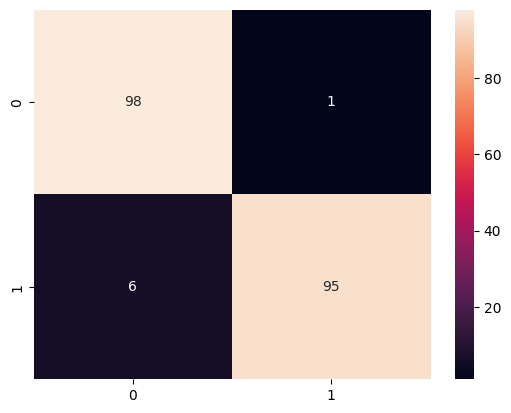

In [177]:
## Print a confusion matrix using the scikit-learn library
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cfm = confusion_matrix(y_test, predictions)

## Plot the confusion matrix
import seaborn as sns

## Visualize the confusion matrix
sns.heatmap(cfm, annot=True, fmt='d')


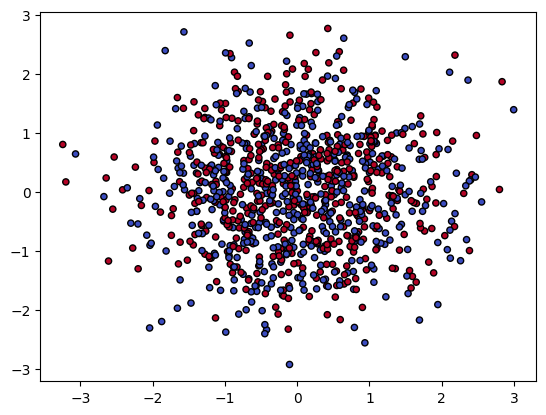

In [178]:
## Let's create a scatter plot of the features in the dataset
import matplotlib.pyplot as plt

# Create a distribution plot of the features
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.show()

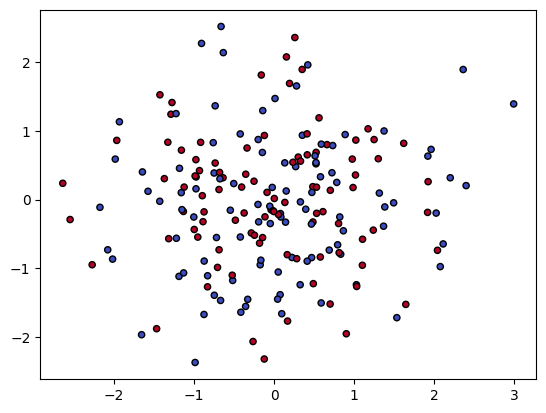

In [179]:
## Plot the features of the test data

plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.show()

<AxesSubplot: ylabel='Count'>

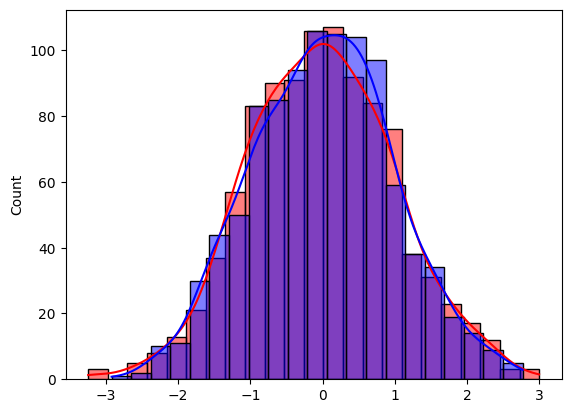

In [180]:
## Create the distribution plot of the features
sns.histplot(X[:, 0], kde=True, color='red', label='Feature 1')
sns.histplot(X[:, 1], kde=True, color='blue', label='Feature 2')

<AxesSubplot: ylabel='Count'>

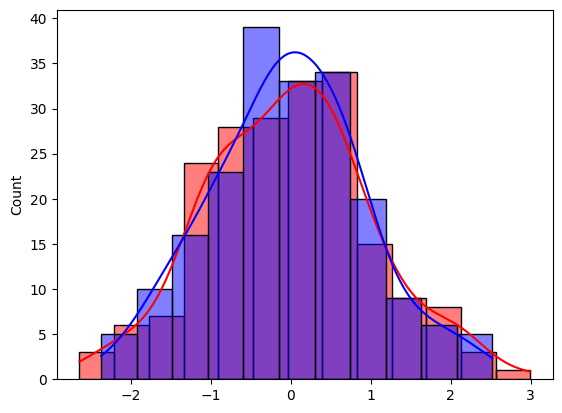

In [181]:
## Plot the distribution of the test data

sns.histplot(X_test[:, 0], kde=True, color='red', label='Feature 1')
sns.histplot(X_test[:, 1], kde=True, color='blue', label='Feature 2')

## Refactoring Code for Naive Bayes Classification

### Naive Bayes Classification Example: Twitter Sentiment Analysis

In [182]:
import nltk
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.corpus import twitter_samples
from nltk.tokenize import TweetTokenizer

In [183]:
## Download the nltk data
nltk.download('twitter_samples')
nltk.download('stopwords')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/james/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to /home/james/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [184]:
## Load the positive and negative tweets

positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

len(positive_tweets), len(negative_tweets)

(5000, 5000)

<AxesSubplot: ylabel='Count'>

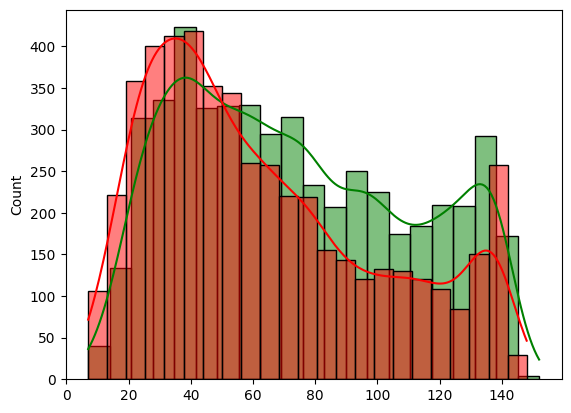

In [185]:
## Let's plot the number of positive and negative tweets

sns.histplot([len(tweet) for tweet in positive_tweets], kde=True, color='green', label='Positive')
sns.histplot([len(tweet) for tweet in negative_tweets], kde=True, color='red', label='Negative')

In [186]:
## Let's use sklearn to split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(positive_tweets + negative_tweets,
                                                    np.append(np.ones(len(positive_tweets)),
                                                    np.zeros(len(negative_tweets))),
                                                    test_size=0.2,
                                                    random_state=123)

len(X_train), len(X_test), len(y_train), len(y_test)


(8000, 2000, 8000, 2000)

In [187]:
X_train[0], X_test[0], y_train[0], y_test[0]

('I had a dream that I met Karlie Kloss &amp; she was so so sweet &amp; she wanted to take like a bunch of goofy photos with me. :(',
 "shadowplaylouis we recently got this mutual and I'm really loving your tweets and everything your about so yay that's exciting :)",
 0.0,
 1.0)

<AxesSubplot: ylabel='Count'>

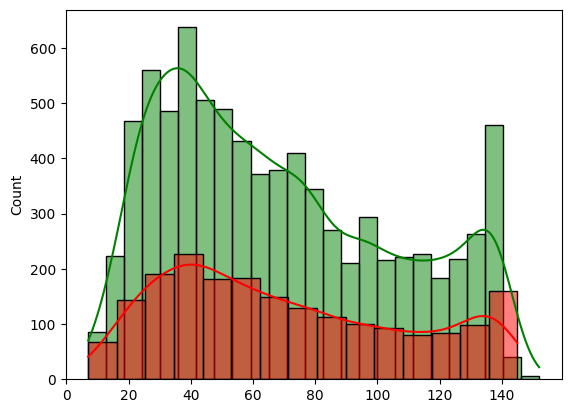

In [188]:
## Plot the length of the tweets re. positive and negative tweets in the training and test sets

sns.histplot([len(tweet) for tweet in X_train], kde=True, color='green', label='Positive', legend=True)
sns.histplot([len(tweet) for tweet in X_test], kde=True, color='red', label='Negative', legend=True)

<AxesSubplot: >

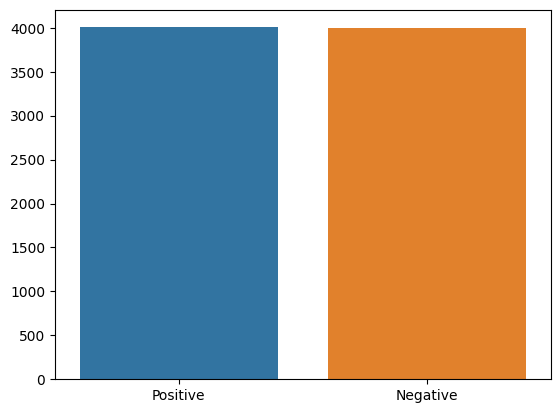

In [189]:
# Let's plot the distribution of the classes in the training and test sets

sns.barplot(x=['Positive', 'Negative'], y=[len(y_train[y_train == 1]), len(y_train[y_train == 0])])

<AxesSubplot: >

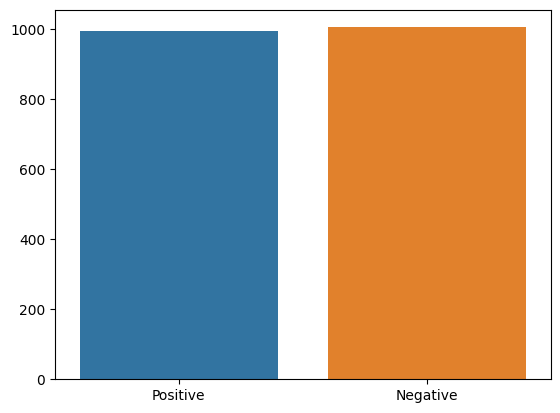

In [190]:
sns.barplot(x=['Positive', 'Negative'], y=[len(y_test[y_test == 1]), len(y_test[y_test == 0])])

### Preprocessing and cleaning the tweets

In [193]:
### Preprocess the data
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def process_tweet(tweet):
    """Input: tweet a string containing a tweet
    Return:
    tweets_clean: a list of words containing the processed tweet
    """
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    
    # Instantiate stemmer class
    stemmer = PorterStemmer()
    
    # Create stopwords list
    stopwords_english = stopwords.words('english')
    
    # Tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    # Tokenize the tweets
    tweet_tokens = tokenizer.tokenize(tweet)
    
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and word not in string.punctuation):
            stem_word = stemmer.stem(word)
            tweets_clean.append(stem_word)
    
    return tweets_clean

### Importing Sntwitter to scrape tweets

In [194]:
## Let's test the function
import snscrape.modules.twitter as sntwitter

test_tweets = []

for i, tweet in enumerate(sntwitter.TwitterSearchScraper('#MurdaughTrial').get_items()):
    if i > 2:
        break
    test_tweets.append(tweet.content)
    
test_tweets

/tmp/ipykernel_1337343/658955367.py:9: FutureWarning: content is deprecated, use rawContent instead
  test_tweets.append(tweet.content)


['I’m going to miss hearing the bailiff shout “the jury is present sir” #MurdaughTrial',
 'Re-upping this tweet after all the evidence and arguments.  #MurdaughTrial',
 '@CourtTV #MurdaughTrial   ❤️Marie from NY. You’re my favorite!']

### Clean the scraped tweets

In [195]:
## Clean the tweets

test_tweets_cleaned = [process_tweet(tweet) for tweet in test_tweets]
test_tweets_cleaned

[['’',
  'go',
  'miss',
  'hear',
  'bailiff',
  'shout',
  '“',
  'juri',
  'present',
  'sir',
  '”',
  'murdaughtri'],
 ['re-up', 'tweet', 'evid', 'argument', 'murdaughtri'],
 ['murdaughtri', '❤', '️mari', 'ny', '’', 'favorit']]

### Create a dictionary of words and their frequencies

In [196]:
## Let's create a dictionary of words and their frequencies
def count_tweets(result, tweets, ys):
    """Input:
    result: a dictionary that will contain the frequency of each pair (word, label)
    tweets: a list of tweets
    ys: an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    """
    # iterate through each tweet and its label
    for y, tweet in zip(ys, tweets):
        # process the tweet to get the words in the form of a list
        for word in process_tweet(tweet):
            # increment the word count for the pair (word, label)
            pair = (word, y)
            if pair in result:
                result[pair] += 1
            else:
                result[pair] = 1
    return result

### Generate a pseudo-labeled dataset

In [197]:
## Let's test our function with our test tweets

result = {}
tweets = test_tweets
ys = np.ones(len(tweets))
count_tweets(result, tweets, ys)

{('’', 1.0): 2,
 ('go', 1.0): 1,
 ('miss', 1.0): 1,
 ('hear', 1.0): 1,
 ('bailiff', 1.0): 1,
 ('shout', 1.0): 1,
 ('“', 1.0): 1,
 ('juri', 1.0): 1,
 ('present', 1.0): 1,
 ('sir', 1.0): 1,
 ('”', 1.0): 1,
 ('murdaughtri', 1.0): 3,
 ('re-up', 1.0): 1,
 ('tweet', 1.0): 1,
 ('evid', 1.0): 1,
 ('argument', 1.0): 1,
 ('❤', 1.0): 1,
 ('️mari', 1.0): 1,
 ('ny', 1.0): 1,
 ('favorit', 1.0): 1}

### Train our Naive Bayes classifier

In [198]:
## Let's train our model

freqs = count_tweets({}, X_train, y_train)

### Examine the results dictionary

In [199]:
freqs

{('dream', 0.0): 18,
 ('met', 0.0): 7,
 ('karli', 0.0): 1,
 ('kloss', 0.0): 1,
 ('sweet', 0.0): 7,
 ('want', 0.0): 201,
 ('take', 0.0): 31,
 ('like', 0.0): 182,
 ('bunch', 0.0): 2,
 ('goofi', 0.0): 1,
 ('photo', 0.0): 11,
 (':(', 0.0): 3668,
 ('serious', 0.0): 9,
 ('go', 0.0): 179,
 ('back', 0.0): 97,
 ('follow', 1.0): 293,
 ('“', 0.0): 13,
 ('paper', 0.0): 15,
 ('town', 0.0): 13,
 ('”', 0.0): 10,
 ('sm', 0.0): 4,
 ('ek', 1.0): 1,
 (':)', 1.0): 2818,
 ('want', 1.0): 82,
 ('ff', 1.0): 37,
 ("thát'", 0.0): 1,
 ("i'v", 0.0): 58,
 ('wrong', 0.0): 23,
 ('powerpoint', 0.0): 1,
 ('present', 0.0): 5,
 ('expect', 0.0): 5,
 ('diner', 0.0): 1,
 ('no-no', 0.0): 1,
 ('either', 0.0): 7,
 ('deactiv', 0.0): 5,
 ('acc', 0.0): 7,
 ('otwolgrandtrail', 0.0): 4,
 ('one', 1.0): 104,
 ('leg', 1.0): 5,
 ('septemb', 1.0): 5,
 ('perhap', 1.0): 3,
 ('bb', 1.0): 3,
 ('promot', 1.0): 3,
 ('full', 1.0): 12,
 ('album', 1.0): 3,
 (':d', 1.0): 512,
 ('best', 1.0): 51,
 ('recent', 1.0): 8,
 ('arsen', 1.0): 2,
 ('news',

### Define a Naive Bayes classifier

In [200]:
## Let's create a function to extract the features from the tweets

def naive_bayes(freqs, X_train, y_train):
    """Train a Naive Bayes classifier on twitter data.

    Args:
        freqs (dict): dictionary of (word, label): frequency pairs
        X_train (list): list of tweets
        y_train (list): list of tweets
        
    returns:
    logprior (float): log prior
    loglikelihood (dict): dictionary of (word, label): log likelihood pairs
    """
    ## Compare the code here with Jurafsky and Martin's pseudocode
    
    loglikelihood = {}
    logprior = 0
    
    vocab = set([pair[0] for pair in freqs.keys()]) # words in the vocabulary
    V = len(vocab) # number of unique words in the vocabulary
    
    # Calculate N_pos and N_neg tweets (number of positive and negative tweets)
    N_pos, N_neg = 0, 0 # number of positive and negative tweets
    
    # Calculate the number of positive and negative tweets
    for pair in freqs.keys():
        # positive tweets
        if pair[1] > 0:
            N_pos += freqs[pair]
        # negative tweets
        else:
            N_neg += freqs[pair]
    
    # Documents = total number of tweets
    D = len(X_train)
    
    # Calculate # of positive and negative documents
    D_pos = np.sum(y_train)
    D_neg = D - D_pos
    
    logprior = np.log(D_pos) - np.log(D_neg)
    
    for word in vocab:
        
        freq_pos = freqs.get((word, 1.0), 0)
        freq_neg = freqs.get((word, 0.0), 0)
        
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)
        
        loglikelihood[word] = np.log(p_w_pos / p_w_neg)
    
    return logprior, loglikelihood
    

In [201]:
## Let's test our function
logprior, loglikelihood = naive_bayes(freqs, X_train, y_train)

In [202]:
logprior, loglikelihood # most probable class given the tweet

(0.0030000022500029644,
 {'progress': -0.0016427908858235695,
  'creak': 0.6915043896741218,
  'paid': -1.611080703319924,
  '482': -0.6947899714457688,
  'preview': 0.6915043896741218,
  'ivan': -0.6947899714457688,
  'envi': -0.6947899714457688,
  'emili': 1.384651570234067,
  'photocard': -0.6947899714457688,
  'pig': -0.0016427908858235695,
  'limbo': 0.6915043896741218,
  'drink': 0.11614024477055976,
  'viral': -0.6947899714457688,
  'nm': -0.6947899714457688,
  'plank': -0.6947899714457688,
  'siddiqu': 0.6915043896741218,
  'chesti': -0.6947899714457688,
  'cheshir': 0.6915043896741218,
  'lorenangel': 0.6915043896741218,
  'pet': 0.40382231722234074,
  'opossum': 0.6915043896741218,
  'anything.sur': -0.6947899714457688,
  'krispi': -0.6947899714457688,
  'peopl': -0.5696268284917627,
  'uncount': 0.6915043896741218,
  'climat': -0.6947899714457688,
  'daddi': -0.6947899714457688,
  'silent': -0.6947899714457688,
  'allow': -0.6947899714457688,
  'therein': 0.6915043896741218,

In [203]:
## Let's test our model

def predict_naive_bayes(tweet, logprior, loglikelihood):
    """Input:
    tweet: a string
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)
    """
    word_l = process_tweet(tweet)
    
    p = 0
    p += logprior
    
    for word in word_l:
        if word in loglikelihood:
            p += loglikelihood[word]
    
    return p

In [204]:
## Let's use our tweets from above

for t in test_tweets:
    print( '%s -> %f' % (t, predict_naive_bayes(t, logprior, loglikelihood)))

I’m going to miss hearing the bailiff shout “the jury is present sir” #MurdaughTrial -> -2.042081
Re-upping this tweet after all the evidence and arguments.  #MurdaughTrial -> 0.416301
@CourtTV #MurdaughTrial   ❤️Marie from NY. You’re my favorite! -> 0.607100


In [205]:
## Let's test our model on the test set

def test_naive_bayes(X_test, y_test, logprior, loglikelihood):
    """Input:
    X_test: a list of tweets
    y_test: (m, 1) array with the sentiment label of each tweet (either 0 or 1)
    logprior: a number
    loglikelihood: a dictionary of words mapping to numbers
    Output:
    accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    
    # Let's score the accuracy of our model
    accuracy = 0
    
    # Our predictions will be stored in y_hat
    y_hat = []
    
    for tweet in X_test:
        if predict_naive_bayes(tweet, logprior, loglikelihood) > 0:
            y_hat.append(1)
        else:
            y_hat.append(0)
    
    # error is the average of the absolute values of the differences between y_hat and y_test
    error = np.mean(np.abs(y_hat - y_test))
    
    accuracy = 1 - error
    
    return accuracy

In [206]:
## Let's test our function
print("Naive Bayes accuracy = %f" % test_naive_bayes(X_test, y_test, logprior, loglikelihood))

Naive Bayes accuracy = 0.992000


In [207]:
## Let's visualize some examples
X_test[0:10], y_test[0:10]

(["shadowplaylouis we recently got this mutual and I'm really loving your tweets and everything your about so yay that's exciting :)",
  '@TheEmblaze @cnni ISIS Chan!! :D',
  'poor them they must be so tired :(',
  '@cinnamoniboni I wish I could! Maybe one year :)',
  '@tamitrailscapes have a great weekend Tami and thank you!:))',
  "it's not okay now, but i will be okay :)",
  "@irisharry_ Awww no :( I didn't mean to make you sad! - Mike",
  '@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
  '@SarahH9977 Thanks hun. Shame one of the sxrew on ends came off and dissappeared. Alot of swapping around and bleeding all over the place.:(',
  '@KimbleFrench Morning Kim. Sorry to hear this. Can you shed some light on the issue so we can look into this? :) Helen'],
 array([1., 1., 0., 1., 1., 1., 0., 1., 0., 1.]))

## Beyond Naivete: Where Naive Bayes Classification Breaks Down

In [208]:
def get_ratio(freqs, word):
    '''
    Input:
        freqs: dictionary containing the words
        word: string to lookup

    Output: a dictionary with keys 'positive', 'negative', and 'ratio'.
        Example: {'positive': 10, 'negative': 20, 'ratio': 0.5}
    '''
    pos_neg_ratio = {'positive': 0, 'negative': 0, 'ratio': 0.0}
    
    
    pos_neg_ratio['positive'] = freqs.get((word, 1.0), 0)

    pos_neg_ratio['negative'] = freqs.get((word, 0.0), 0)

    # calculate the ratio of positive to negative counts for the word
    pos_neg_ratio['ratio'] = (pos_neg_ratio['positive'] + 1)/(pos_neg_ratio['negative'] + 1)
    
    return pos_neg_ratio


def threshold_lookup(freqs, label, threshold):
    """Input:
    freqs: dictionary of (word, label): frequency pairs
    threshold: words position in the scored list
    """

    words = {}

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    for key in freqs.keys():
        word, _ = key

        # get the positive/negative ratio for a word
        pos_neg_ratio = get_ratio(freqs, word)

        # if the label is 1 and the ratio is greater than or equal to the threshold...
        if label == 1 and pos_neg_ratio['ratio'] >= threshold:

            # Add the pos_neg_ratio to the dictionary
            words[word] = pos_neg_ratio

        # If the label is 0 and the pos_neg_ratio is less than or equal to the threshold...
        elif label == 0 and pos_neg_ratio['ratio'] <= threshold:

            # Add the pos_neg_ratio to the dictionary
            words[word] = pos_neg_ratio
            
    return words

In [210]:
get_ratio(freqs, 'peopl')

{'positive': 33, 'negative': 59, 'ratio': 0.5666666666666667}

In [212]:
threshold_lookup(freqs, label=1, threshold=2.0)

{'ek': {'positive': 1, 'negative': 0, 'ratio': 2.0},
 ':)': {'positive': 2818, 'negative': 2, 'ratio': 939.6666666666666},
 'ff': {'positive': 37, 'negative': 4, 'ratio': 7.6},
 'septemb': {'positive': 5, 'negative': 2, 'ratio': 2.0},
 'perhap': {'positive': 3, 'negative': 1, 'ratio': 2.0},
 ':d': {'positive': 512, 'negative': 0, 'ratio': 513.0},
 'best': {'positive': 51, 'negative': 17, 'ratio': 2.888888888888889},
 'recent': {'positive': 8, 'negative': 0, 'ratio': 9.0},
 'arsen': {'positive': 2, 'negative': 0, 'ratio': 3.0},
 'new': {'positive': 116, 'negative': 43, 'ratio': 2.659090909090909},
 'lad': {'positive': 1, 'negative': 0, 'ratio': 2.0},
 'amyjackson': {'positive': 1, 'negative': 0, 'ratio': 2.0},
 '21': {'positive': 2, 'negative': 0, 'ratio': 3.0},
 'hahahaaah': {'positive': 1, 'negative': 0, 'ratio': 2.0},
 'owli': {'positive': 1, 'negative': 0, 'ratio': 2.0},
 'knock': {'positive': 3, 'negative': 1, 'ratio': 2.0},
 'good': {'positive': 195, 'negative': 79, 'ratio': 2.45}

In [213]:
# Some error analysis done for you
print('Truth Predicted Tweet')
for x, y in zip(X_test, y_test):
    # get the label prediction for the tweet
    y_hat = predict_naive_bayes(x, logprior, loglikelihood)
    
    # if the prediction is not equal to the label, print the tweet and the prediction
    if y != (np.sign(y_hat) > 0):
        
        # print out the gold label ('y'), the predicted label ('y_hat'), and the tweet ('x')
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            process_tweet(x)).encode('ascii', 'ignore')))

Truth Predicted Tweet
0	1.00	b'laomma design kebaya wed dress bandung indonesia line laomma 7df89150 whatsapp 62 08962464174 7 instagram laomma_coutur'
0	1.00	b"corbyn must understand labour' new member chang party' fortun"
0	1.00	b' love spot robinhood wild thank support robinhoodi  '
0	1.00	b'huhuu thank congratul proud guy idea happi thank support :('
1	0.00	b'jealou :) ye plezzz  im hungri rn'
1	0.00	b'kik qualki 808 kik kikmenow milf like 4like bore summer sexysaturday :)'
1	0.00	b'guy add kik therver 85552 kik hornykik bestoftheday girl wife premiostumundo oralsex :)'
0	1.00	b'look good pal glad paid  111 jersey gilet'
1	0.00	b'kid certain action littl grunt'
0	1.00	b'hug baek tight'
0	1.00	b'rohingya muslim 72 indict human traffick charg thailand asia around ...'
1	0.00	b'go'
1	0.00	b'new report talk burn calori cold work harder warm feel better weather :p'
0	1.00	b'win ticket codi simpson concert singapor august 10'
0	1.00	b'hi skulker check thread'
1	0.00	b'kik hatessuc 32429 